# Labels Clientes Activos - Inactivos

En este notebook nos concetramos principalmente en categorizar a los clientes como Activos e inactivos considerando los aprendizajes del analisis exploratorio de los datos.

Las consideraciones son las siguientes:
    1. A
    2. B
    3. C

### Mejoras - Futuros cambios

    a.- Leer query desde archivo plano.
    b.- Considerar meses de actividad vs meses con compra (distincion entre 1 mes de compra cliente nuevo vs un cliente inactivo).
    c.- Estimar/calcular tasa de segunda compra  y tiempo transcurrido entre primera y segunda compra.
    d.- Con el punto anterior obtener periodo "critico" de retención y definir cuando un cliente deja de ser considerado           como nuevo

In [1]:
# Importamos librerias a utilizar
import pandas as pd
import numpy as np
from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Conexion a GCP - BigQuery
import pydata_google_auth
from google.cloud import bigquery
SCOPES = [
    'https://www.googleapis.com/auth/cloud-platform',
    'https://www.googleapis.com/auth/drive',
]
credentials = pydata_google_auth.get_user_credentials(
    SCOPES,
    auth_local_webserver=True,
)
client = bigquery.Client(project='gasco-analytics', credentials=credentials)

In [3]:
# Query a Ejecutar
query = """
SELECT A.*,
      CASE  WHEN A.n_canales = 2 THEN 'ON-OFF'
            WHEN A.n_canales = 1 AND tipo_pedido = 'ONLINE' THEN 'ONLINE'
            WHEN A.n_canales = 1 AND tipo_pedido = 'OFFLINE' THEN 'OFFLINE'
      END AS TIPO_CLIENTE,
      B.predict_estufa,
      B.predict_parrilla,
      B.predict_cocina,
      B.predict_calefont
FROM(
      SELECT CAST(TELEFONO AS INT64) AS TELEFONO,
             SUM(IND_TA) AS PEDIDOS_TA,
             SUM(KILOS_TA) AS KILOS_TA,
             COUNT(DISTINCT createdAT) AS TOTAL_PEDIDOS,
             SUM(total_kilos_pedido) AS TOTAL_KILOS,
             COUNT(DISTINCT MONTH) AS MESES_COMPRA,
             MIN(EXTRACT(DATE FROM createdAt)) AS FECHA_PRIMER_PEDIDO,
             MAX(EXTRACT(DATE FROM createdAt)) AS FECHA_ULTIMO_PEDIDO,
             AVG(dias_compra) AS frec_compra_promedio, 
             stddev(dias_compra) AS desv_frec_compra,
             COUNT(DISTINCT TIPO_PEDIDO_BIEN) AS n_canales, 
             MAX(TIPO_PEDIDO_BIEN) AS tipo_pedido 
      FROM(
            SELECT *, 
                  DATE_DIFF(EXTRACT(DATE FROM createdat),LAG(EXTRACT(DATE FROM createdat)) OVER(PARTITION BY Telefono ORDER BY EXTRACT(DATE FROM createdat)), DAY) AS dias_compra 
            FROM(
                  SELECT *,
                        EXTRACT(YEAR FROM createdAt) AS YEAR,
                        EXTRACT(MONTH FROM createdAt) as MONTH,
                        CASE WHEN mes in (5,6,7,8,9) THEN 1 ELSE 0 END AS IND_TA,
                        CASE WHEN mes in (5,6,7,8,9) THEN total_kilos_pedido ELSE 0 END AS KILOS_TA,
                        CASE WHEN tipo_pedido_bien = 'OFFLINE' THEN customerNoIfOffline
                              WHEN tipo_pedido_bien = 'ONLINE' THEN mobile
                              ELSE mobile END AS Telefono,
                        CASE WHEN status = 'COMPLETED' THEN 'COMPLETADO' ELSE 'NO COMPLETADO' END AS ESTADO_PEDIDO, 
                  FROM `gasco-analytics.gasco.pedidos_gasconnect_todos_javier`
                  WHERE CAST(createdAt as DATE) BETWEEN @INI_DATE AND @TER_DATE --SELECCIONA LOS PEDIDOS DE UN AÑO MOVIL
                  AND isAnulled IS NULL     --PEDIDO NO ANULADO
                  --AND mobile IS NOT NULL    --TELEFONO NO NULO
                  AND TIPO_PEDIDO_BIEN IN ('OFFLINE', 'ONLINE')
            )
            WHERE ESTADO_PEDIDO = 'COMPLETADO'
      )
      GROUP BY TELEFONO
) AS A   

LEFT JOIN `gasco-analytics.gasco_modelos.20210218_prediccion_modelo_uso_gas` AS B  
ON(A.TELEFONO = B.telefono)
"""

In [4]:
from dateutil.relativedelta import relativedelta

fecha_ter = date.today()
fecha_ini = fecha_ter - relativedelta(years = 1)
fecha_ini = fecha_ini.replace(day = 1)


job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter('INI_DATE', 'DATE', fecha_ini),
        bigquery.ScalarQueryParameter('TER_DATE', 'DATE', fecha_ter),
    ]
)

print(fecha_ini, fecha_ter)

2020-04-01 2021-04-20


#### Fecha actualizacion: 2021-04-12

In [5]:
read_data = True
if read_data:
    df_fuga = pd.read_csv('datos\datos_labeling_fuga.csv',sep = ';', index_col = 0)
else:
    query_job = client.query(query,job_config=job_config)  # API request
    #rows = query_job.result()  # Waits for query to finish
    df_fuga = query_job.to_dataframe()

    #guardamos como csv los datos
    df_fuga.to_csv('datos\datos_labeling_fuga.csv',sep = ';')

df_fuga.head(2)

,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont
0,222183113.0,10,154,11,165,5,2020-06-10,2020-10-01,11.30,5.355164,1,OFFLINE,OFFLINE,1.0,0.0,0.0,0.0
1,225056837.0,5,65,9,115,6,2020-06-26,2021-03-19,33.25,30.686200,1,OFFLINE,OFFLINE,1.0,0.0,1.0,1.0


In [6]:
n_clientes = len(df_fuga)
columnas = ['MESES_COMPRA','TELEFONO','TOTAL_KILOS','frec_compra_promedio']

data_mensual_agrupada = df_fuga[columnas].groupby('MESES_COMPRA').agg(
                                cant_clientes    = ('TELEFONO','count'),
                                kilos_promedio   = ('TOTAL_KILOS', 'mean'),
                                frec_compra_prom = ('frec_compra_promedio','mean')
                        ).reset_index()


#data_mensual_agrupada = df_fuga[['MESES_COMPRA','TELEFONO']].groupby('MESES_COMPRA').count().reset_index()

data_mensual_agrupada['porcentaje_clientes'] = data_mensual_agrupada['cant_clientes']/n_clientes
data_mensual_agrupada['porcentaje_acum']     = data_mensual_agrupada.porcentaje_clientes.cumsum()

data_mensual_agrupada

,MESES_COMPRA,cant_clientes,kilos_promedio,frec_compra_prom,porcentaje_clientes,porcentaje_acum
0,1,336051,19.456472,12.947593,0.521892,0.521892
1,2,102573,43.629688,78.929551,0.159297,0.681189
2,3,57516,70.313356,60.271383,0.089323,0.770513
3,4,39263,98.873494,49.958334,0.060976,0.831489
4,5,28746,126.226292,43.510091,0.044643,0.876132
5,6,21714,157.425256,38.271475,0.033722,0.909854
6,7,17388,188.997009,33.334449,0.027004,0.936858
7,8,13454,222.310168,29.233414,0.020894,0.957752
8,9,10708,259.150994,25.638672,0.016630,0.974381
9,10,7946,310.531588,22.351501,0.012340,0.986722


In [7]:
import jenkspy

breaks_frec_3 = jenkspy.jenks_breaks(data_mensual_agrupada['frec_compra_prom'], nb_class = 3)
breaks_frec_4 = jenkspy.jenks_breaks(data_mensual_agrupada['frec_compra_prom'], nb_class = 4)
breaks_frec_5 = jenkspy.jenks_breaks(data_mensual_agrupada['frec_compra_prom'], nb_class = 5) 

df_frec = data_mensual_agrupada[['MESES_COMPRA','cant_clientes','frec_compra_prom']]

df_frec['breaks_frec_3'] = pd.cut(data_mensual_agrupada['frec_compra_prom'],
                                              bins=breaks_frec_3,
                                              labels=['grupo_1', 'grupo_2','grupo_3'])

df_frec['breaks_frec_4'] = pd.cut(data_mensual_agrupada['frec_compra_prom'],
                                              bins=breaks_frec_4,
                                              labels=['grupo_1', 'grupo_2','grupo_3','grupo_4'])

df_frec['breaks_frec_5'] = pd.cut(data_mensual_agrupada['frec_compra_prom'],
                                              bins=breaks_frec_5,
                                              labels=['grupo_1', 'grupo_2','grupo_3','grupo_4','grupo_5'])

df_frec

<ipython-input-7-8ebfd27ed832>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frec['breaks_frec_3'] = pd.cut(data_mensual_agrupada['frec_compra_prom'],
<ipython-input-7-8ebfd27ed832>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frec['breaks_frec_4'] = pd.cut(data_mensual_agrupada['frec_compra_prom'],


,MESES_COMPRA,cant_clientes,frec_compra_prom,breaks_frec_3,breaks_frec_4,breaks_frec_5
0,1,336051,12.947593,NaN,NaN,NaN
1,2,102573,78.929551,grupo_3,grupo_4,grupo_5
2,3,57516,60.271383,grupo_3,grupo_3,grupo_4
3,4,39263,49.958334,grupo_2,grupo_3,grupo_4
4,5,28746,43.510091,grupo_2,grupo_2,grupo_3
5,6,21714,38.271475,grupo_2,grupo_2,grupo_3
6,7,17388,33.334449,grupo_2,grupo_2,grupo_2
7,8,13454,29.233414,grupo_1,grupo_2,grupo_2
8,9,10708,25.638672,grupo_1,grupo_1,grupo_2
9,10,7946,22.351501,grupo_1,grupo_1,grupo_1


In [8]:
breaks_kilos_3 = jenkspy.jenks_breaks(data_mensual_agrupada['kilos_promedio'], nb_class = 3)
breaks_kilos_4 = jenkspy.jenks_breaks(data_mensual_agrupada['kilos_promedio'], nb_class = 4)
breaks_kilos_5 = jenkspy.jenks_breaks(data_mensual_agrupada['kilos_promedio'], nb_class = 5) 

df_kilos = data_mensual_agrupada[['MESES_COMPRA','cant_clientes','kilos_promedio']]

df_kilos['breaks_kilos_3'] = pd.cut(data_mensual_agrupada['kilos_promedio'],
                                    bins=breaks_kilos_3,
                                    labels=['grupo_1', 'grupo_2','grupo_3'],
                                    include_lowest=True)

df_kilos['breaks_kilos_4'] = pd.cut(data_mensual_agrupada['kilos_promedio'],
                                    bins=breaks_kilos_4,
                                    labels=['grupo_1', 'grupo_2','grupo_3','grupo_4'],
                                    include_lowest=True)

df_kilos['breaks_kilos_5'] = pd.cut(data_mensual_agrupada['kilos_promedio'],
                                    bins=breaks_kilos_5,
                                    labels=['grupo_1', 'grupo_2','grupo_3','grupo_4','grupo_5'],
                                    include_lowest=True)

df_kilos

<ipython-input-8-abb41cde793f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kilos['breaks_kilos_3'] = pd.cut(data_mensual_agrupada['kilos_promedio'],
<ipython-input-8-abb41cde793f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kilos['breaks_kilos_4'] = pd.cut(data_mensual_agrupada['kilos_promedio'],


,MESES_COMPRA,cant_clientes,kilos_promedio,breaks_kilos_3,breaks_kilos_4,breaks_kilos_5
0,1,336051,19.456472,grupo_1,grupo_1,grupo_1
1,2,102573,43.629688,grupo_1,grupo_1,grupo_1
2,3,57516,70.313356,grupo_1,grupo_1,grupo_1
3,4,39263,98.873494,grupo_1,grupo_1,grupo_2
4,5,28746,126.226292,grupo_1,grupo_2,grupo_2
5,6,21714,157.425256,grupo_1,grupo_2,grupo_2
6,7,17388,188.997009,grupo_2,grupo_2,grupo_3
7,8,13454,222.310168,grupo_2,grupo_2,grupo_3
8,9,10708,259.150994,grupo_2,grupo_3,grupo_3
9,10,7946,310.531588,grupo_2,grupo_3,grupo_4


In [9]:
df_fuga.head(2)

,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,n_canales,tipo_pedido,TIPO_CLIENTE,predict_estufa,predict_parrilla,predict_cocina,predict_calefont
0,222183113.0,10,154,11,165,5,2020-06-10,2020-10-01,11.30,5.355164,1,OFFLINE,OFFLINE,1.0,0.0,0.0,0.0
1,225056837.0,5,65,9,115,6,2020-06-26,2021-03-19,33.25,30.686200,1,OFFLINE,OFFLINE,1.0,0.0,1.0,1.0


<AxesSubplot:xlabel='MESES_COMPRA', ylabel='TOTAL_KILOS'>

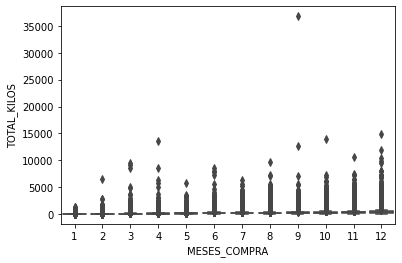

In [10]:
sns.boxplot(data = df_fuga, x = 'MESES_COMPRA', y = 'TOTAL_KILOS')

<AxesSubplot:xlabel='MESES_COMPRA', ylabel='TOTAL_PEDIDOS'>

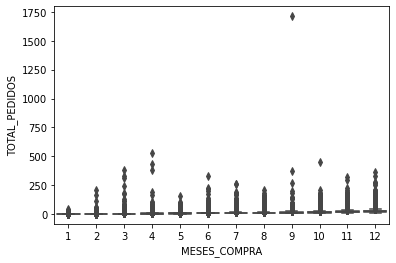

In [11]:
sns.boxplot(data = df_fuga, x = 'MESES_COMPRA', y = 'TOTAL_PEDIDOS')

In [12]:
df_kilos_meses =  df_fuga[['MESES_COMPRA','TOTAL_KILOS']].groupby('MESES_COMPRA').agg([('Q1', lambda x: x.quantile(0.25)),
               ('Q2', lambda x: x.quantile(0.5)),
               ('Q3', lambda x: x.quantile(0.75)),
               ('Q90', lambda x: x.quantile(.90)),
               ('max', max)]
               ).reset_index()
df_kilos_meses

MESES_COMPRA TOTAL_KILOS                           
                         Q1   Q2      Q3    Q90    max
0             1          15   15   20.00   41.0   1397
1             2          30   30   50.00   90.0   6442
2             3          45   56   80.25  130.0   9480
3             4          60   77  116.00  174.0  13676
4             5          77  105  150.00  215.0   5710
5             6          99  130  180.00  257.0   8595
6             7         120  155  214.00  308.0   6391
7             8         142  181  246.00  343.0   9702
8             9         165  211  285.00  390.0  36787
9            10         195  251  334.00  457.5  13965
10           11         227  295  389.00  535.6  10601
11           12         279  360  495.00  709.7  14936

In [13]:
df_fuga_2 = df_fuga.merge(df_kilos_meses, on = 'MESES_COMPRA')

C:\Users\fbenavides\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\fbenavides\Anaconda3\lib\site-packages\pandas\core\generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [14]:
df_fuga_2 = df_fuga_2[df_fuga_2['TOTAL_KILOS'] < df_fuga_2[('TOTAL_KILOS', 'Q90')]]
print(len(df_fuga),len(df_fuga_2),len(df_fuga) - len(df_fuga_2) )

643909 579026 64883


<AxesSubplot:xlabel='MESES_COMPRA', ylabel='TOTAL_KILOS'>

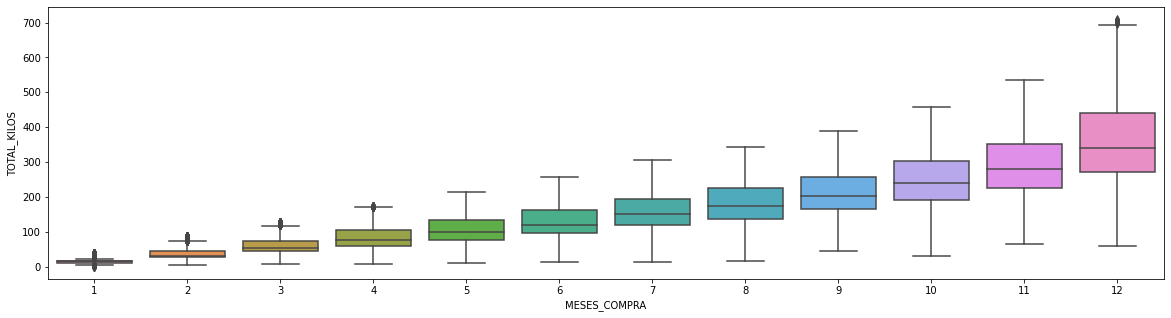

In [15]:
plt.figure(figsize=(20,5))
sns.boxplot(data = df_fuga_2, 
            x = 'MESES_COMPRA', y = 'TOTAL_KILOS')

In [16]:
import datetime

fecha_referencia = datetime.date(2021, 4, 12)

def str_to_date(x):
    date = datetime.datetime.strptime(x, '%Y-%m-%d')
    return(date)

df_fuga_2['fecha_primera_compra'] = df_fuga_2.FECHA_PRIMER_PEDIDO.apply(str_to_date)

In [17]:
def get_diff_by_month(x):
    num_months = (fecha_referencia.year - x.year)*12 + (fecha_referencia.month - x.month)
    return(num_months)

df_fuga_2['meses_permanencia'] = df_fuga_2.fecha_primera_compra.apply(get_diff_by_month) + 1
df_fuga_2['tasa_meses'] = df_fuga_2['MESES_COMPRA']/df_fuga_2['meses_permanencia']
df_fuga_2.head()

,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,...,predict_cocina,predict_calefont,"(TOTAL_KILOS, Q1)","(TOTAL_KILOS, Q2)","(TOTAL_KILOS, Q3)","(TOTAL_KILOS, Q90)","(TOTAL_KILOS, max)",fecha_primera_compra,meses_permanencia,tasa_meses
0,222183113.0,10,154,11,165,5,2020-06-10,2020-10-01,11.300000,5.355164,...,0.0,0.0,77,105,150.0,215.0,5710,2020-06-10,11,0.454545
1,323617342.0,4,40,5,55,5,2020-05-26,2020-10-21,37.000000,31.251667,...,1.0,1.0,77,105,150.0,215.0,5710,2020-05-26,12,0.416667
2,933759684.0,13,167,14,182,5,2020-04-10,2020-08-28,10.769231,9.773722,...,0.0,0.0,77,105,150.0,215.0,5710,2020-04-10,13,0.384615
3,934234442.0,4,32,7,53,5,2020-08-12,2021-03-01,33.500000,40.198259,...,1.0,1.0,77,105,150.0,215.0,5710,2020-08-12,9,0.555556
4,947983480.0,10,113,11,124,5,2020-04-30,2020-08-29,12.100000,8.912538,...,1.0,1.0,77,105,150.0,215.0,5710,2020-04-30,13,0.384615


In [18]:
meses_permanencia = df_fuga_2.groupby('meses_permanencia').count().reset_index()
meses_permanencia

,meses_permanencia,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,...,predict_parrilla,predict_cocina,predict_calefont,"(TOTAL_KILOS, Q1)","(TOTAL_KILOS, Q2)","(TOTAL_KILOS, Q3)","(TOTAL_KILOS, Q90)","(TOTAL_KILOS, max)",fecha_primera_compra,tasa_meses
0,1,16078,16078,16078,16078,16078,16078,16078,16078,504,...,1560,1560,1560,16078,16078,16078,16078,16078,16078,16078
1,2,25650,25650,25650,25650,25650,25650,25650,25650,3590,...,2649,2649,2649,25650,25650,25650,25650,25650,25650,25650
2,3,21189,21189,21189,21189,21189,21189,21189,21189,4388,...,13654,13654,13654,21189,21189,21189,21189,21189,21189,21189
3,4,20514,20514,20514,20514,20514,20514,20514,20514,5294,...,20499,20499,20499,20514,20514,20514,20514,20514,20514,20514
4,5,23487,23487,23487,23487,23487,23487,23487,23487,7012,...,23470,23470,23470,23487,23487,23487,23487,23487,23487,23487
5,6,26847,26847,26847,26847,26847,26847,26847,26847,8697,...,26828,26828,26828,26847,26847,26847,26847,26847,26847,26847
6,7,32953,32953,32953,32953,32953,32953,32953,32953,12055,...,32928,32928,32928,32953,32953,32953,32953,32953,32953,32953
7,8,42104,42104,42104,42104,42104,42104,42104,42104,16229,...,42072,42072,42072,42104,42104,42104,42104,42104,42104,42104
8,9,62794,62794,62794,62794,62794,62794,62794,62794,28805,...,62751,62751,62751,62794,62794,62794,62794,62794,62794,62794
9,10,83728,83728,83728,83728,83728,83728,83728,83728,47750,...,83626,83626,83626,83728,83728,83728,83728,83728,83728,83728


<AxesSubplot:xlabel='meses_permanencia', ylabel='TELEFONO'>

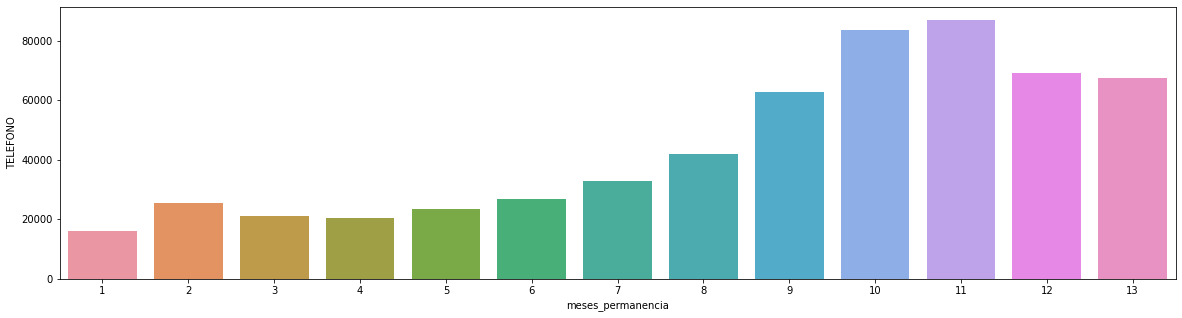

In [19]:
plt.figure(figsize=(20,5))
sns.barplot(data = meses_permanencia, 
            x = 'meses_permanencia', y = 'TELEFONO')

<AxesSubplot:xlabel='MESES_COMPRA', ylabel='cant_clientes'>

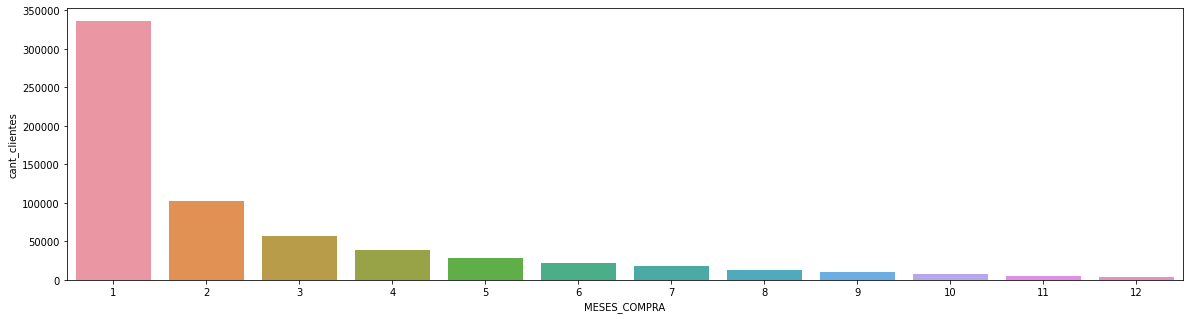

In [20]:
plt.figure(figsize=(20,5))
sns.barplot(data = data_mensual_agrupada, 
            x = 'MESES_COMPRA', y = 'cant_clientes')

### Cortes preliminares basados en meses con compra

Basados en los cortes de Jenkis considerando el dataframe sin outliers obtenemos:

In [21]:
df_fuga_2.head(2)

,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,...,predict_cocina,predict_calefont,"(TOTAL_KILOS, Q1)","(TOTAL_KILOS, Q2)","(TOTAL_KILOS, Q3)","(TOTAL_KILOS, Q90)","(TOTAL_KILOS, max)",fecha_primera_compra,meses_permanencia,tasa_meses
0,222183113.0,10,154,11,165,5,2020-06-10,2020-10-01,11.3,5.355164,...,0.0,0.0,77,105,150.0,215.0,5710,2020-06-10,11,0.454545
1,323617342.0,4,40,5,55,5,2020-05-26,2020-10-21,37.0,31.251667,...,1.0,1.0,77,105,150.0,215.0,5710,2020-05-26,12,0.416667


In [22]:
data_mensual_agrupada_2 = df_fuga_2[columnas].groupby('MESES_COMPRA').agg(
                                cant_clientes    = ('TELEFONO','count'),
                                kilos_promedio   = ('TOTAL_KILOS', 'mean'),
                                frec_compra_prom = ('frec_compra_promedio','mean')
                        ).reset_index()


#data_mensual_agrupada = df_fuga[['MESES_COMPRA','TELEFONO']].groupby('MESES_COMPRA').count().reset_index()

data_mensual_agrupada_2['porcentaje_clientes'] = data_mensual_agrupada_2['cant_clientes']/len(df_fuga_2)
data_mensual_agrupada_2['porcentaje_acum']     = data_mensual_agrupada_2.porcentaje_clientes.cumsum()

data_mensual_agrupada_2

,MESES_COMPRA,cant_clientes,kilos_promedio,frec_compra_prom,porcentaje_clientes,porcentaje_acum
0,1,302103,15.722949,13.468731,0.521743,0.521743
1,2,92227,35.538508,78.140562,0.159280,0.681023
2,3,51748,57.584486,60.071313,0.089371,0.770394
3,4,35332,81.717933,50.136374,0.061020,0.831413
4,5,25867,106.454247,43.929005,0.044673,0.876087
5,6,19535,131.154236,38.859911,0.033738,0.909824
6,7,15648,158.140721,34.011906,0.027025,0.936849
7,8,12102,183.809205,29.947678,0.020901,0.957750
8,9,9620,213.211642,26.328570,0.016614,0.974364
9,10,7151,250.955531,23.109113,0.012350,0.986714


In [23]:
breaks_frec_2 = jenkspy.jenks_breaks(data_mensual_agrupada_2['frec_compra_prom'], nb_class = 2)
breaks_frec_3 = jenkspy.jenks_breaks(data_mensual_agrupada_2['frec_compra_prom'], nb_class = 3)
breaks_frec_4 = jenkspy.jenks_breaks(data_mensual_agrupada_2['frec_compra_prom'], nb_class = 4)
breaks_frec_5 = jenkspy.jenks_breaks(data_mensual_agrupada_2['frec_compra_prom'], nb_class = 5) 

df_frec_2 = data_mensual_agrupada_2[['MESES_COMPRA','cant_clientes','frec_compra_prom']]

df_frec_2['breaks_frec_2'] = pd.cut(data_mensual_agrupada_2['frec_compra_prom'],
                                              bins=breaks_frec_2,
                                              labels=['grupo_1', 'grupo_2'])

df_frec_2['breaks_frec_3'] = pd.cut(data_mensual_agrupada_2['frec_compra_prom'],
                                              bins=breaks_frec_3,
                                              labels=['grupo_1', 'grupo_2','grupo_3'])

df_frec_2['breaks_frec_4'] = pd.cut(data_mensual_agrupada_2['frec_compra_prom'],
                                              bins=breaks_frec_4,
                                              labels=['grupo_1', 'grupo_2','grupo_3','grupo_4'])

df_frec_2['breaks_frec_5'] = pd.cut(data_mensual_agrupada_2['frec_compra_prom'],
                                              bins=breaks_frec_5,
                                              labels=['grupo_1', 'grupo_2','grupo_3','grupo_4','grupo_5'])

df_frec_2['breaks_frec_2'] = df_frec_2['breaks_frec_2'].fillna('grupo_2')
df_frec_2['breaks_frec_3'] = df_frec_2['breaks_frec_3'].fillna('grupo_3')
df_frec_2['breaks_frec_4'] = df_frec_2['breaks_frec_4'].fillna('grupo_4')
df_frec_2['breaks_frec_5'] = df_frec_2['breaks_frec_5'].fillna('grupo_5')

#df_frec_2.to_csv('cortes_frecuencia.csv', = ';')

<ipython-input-23-d5738c7f7e6a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frec_2['breaks_frec_2'] = pd.cut(data_mensual_agrupada_2['frec_compra_prom'],
<ipython-input-23-d5738c7f7e6a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_frec_2['breaks_frec_3'] = pd.cut(data_mensual_agrupada_2['frec_compra_prom'],


In [24]:
#breaks_kilos_3 = jenkspy.jenks_breaks(data_mensual_agrupada_2['kilos_promedio'], nb_class = 3)
#breaks_kilos_4 = jenkspy.jenks_breaks(data_mensual_agrupada_2['kilos_promedio'], nb_class = 4)
#breaks_kilos_5 = jenkspy.jenks_breaks(data_mensual_agrupada_2['kilos_promedio'], nb_class = 5) 

#df_kilos_2 = data_mensual_agrupada_2[['MESES_COMPRA','cant_clientes','kilos_promedio']]

#df_kilos_2['breaks_kilos_3'] = pd.cut(data_mensual_agrupada_2['kilos_promedio'],
#                                    bins=breaks_kilos_3,
#                                    labels=['grupo_1', 'grupo_2','grupo_3'],
#                                    include_lowest=True)

#df_kilos_2['breaks_kilos_4'] = pd.cut(data_mensual_agrupada_2['kilos_promedio'],
#                                    bins=breaks_kilos_4,
#                                    labels=['grupo_1', 'grupo_2','grupo_3','grupo_4'],
#                                    include_lowest=True)

#df_kilos_2['breaks_kilos_5'] = pd.cut(data_mensual_agrupada_2['kilos_promedio'],
#                                    bins=breaks_kilos_5,
#                                    labels=['grupo_1', 'grupo_2','grupo_3','grupo_4','grupo_5'],
#                                    include_lowest=True)

#df_kilos_2

In [25]:
choices_NB = ['inacto','activo bajo','activo alto']

conditions_NB = [
       (df_fuga_2['MESES_COMPRA'] <= 3), 
       ((df_fuga_2['MESES_COMPRA'] > 3) & (df_fuga_2['MESES_COMPRA'] <= 7)),
       (df_fuga_2['MESES_COMPRA'] > 7)]

choices_B = ['inacto','activo']

conditions_B = [
       (df_fuga_2['MESES_COMPRA'] <= 5), 
       (df_fuga_2['MESES_COMPRA'] > 5)]

df_fuga_2['estados_no_binarios'] = np.select(conditions_NB, choices_NB, default=np.nan)
df_fuga_2['estados_binarios'] = np.select(conditions_B, choices_B, default=np.nan)

df_fuga_2.head()
df_fuga_2.to_csv('cortes_frecuencia.csv', sep = ';')

In [26]:
df_fuga_2.head()

,TELEFONO,PEDIDOS_TA,KILOS_TA,TOTAL_PEDIDOS,TOTAL_KILOS,MESES_COMPRA,FECHA_PRIMER_PEDIDO,FECHA_ULTIMO_PEDIDO,frec_compra_promedio,desv_frec_compra,...,predict_calefont,"(TOTAL_KILOS, Q1)","(TOTAL_KILOS, Q2)","(TOTAL_KILOS, Q3)","(TOTAL_KILOS, Q90)","(TOTAL_KILOS, max)",fecha_primera_compra,meses_permanencia,tasa_meses,estados_binarios
0,222183113.0,10,154,11,165,5,2020-06-10,2020-10-01,11.300000,5.355164,...,0.0,77,105,150.0,215.0,5710,2020-06-10,11,0.454545,inacto
1,323617342.0,4,40,5,55,5,2020-05-26,2020-10-21,37.000000,31.251667,...,1.0,77,105,150.0,215.0,5710,2020-05-26,12,0.416667,inacto
2,933759684.0,13,167,14,182,5,2020-04-10,2020-08-28,10.769231,9.773722,...,0.0,77,105,150.0,215.0,5710,2020-04-10,13,0.384615,inacto
3,934234442.0,4,32,7,53,5,2020-08-12,2021-03-01,33.500000,40.198259,...,1.0,77,105,150.0,215.0,5710,2020-08-12,9,0.555556,inacto
4,947983480.0,10,113,11,124,5,2020-04-30,2020-08-29,12.100000,8.912538,...,1.0,77,105,150.0,215.0,5710,2020-04-30,13,0.384615,inacto


In [27]:
df_fuga_2.FECHA_ULTIMO_PEDIDO.max()

'2021-04-19'